#  Exploratory Data Analysis

Σκοπός του παρακάτω κωδικά είναι να εφαρμόσουμε μεθόδους και τεχνικές ανάλυσης στα συλλεχθέντα δεδομένα. 

Η **διερευνητική ανάλυση δεδομένων** μας βοηθάει στη διαδικασία λήψης αποφάσεων και την περαιτέρω βελτίωση του συστήματος.

Μας βοηθά επίσης  στον εντοπισμό «προβληματικών» τιμών, δηλαδή των τιμών της μεταβλητής που  είναι απομακρυσμένες από το σώμα των υπόλοιπων τιμών και να τις χαρακτηρίσουμε ως ακραίες ή έκτροπες ή, ακόμα και λανθασμένες και να αποφασίσουμε για τον τρόπο που θα τις διαχειριστούμε. Ακόμα, μας βοηθά να διαγνώσουμε την Κανονικότητα του πληθυσμού, δηλαδή ελέγξουμε εάν τα δεδομένα μας προέρχονται από έναν πληθυσμό που ακολουθεί την Κανονική Κατανομή.

Εισαγωγή απαραίτητων βιβλιοθηκών

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2

import pydicom
from skimage.transform import resize

# SKLearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

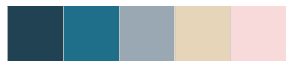

In [48]:
# Set Color Palettes for the notebook
colors_nude = ['#214252','#1f6f8b','#99a8b2','#e6d5b8','#f7dad9']
sns.palplot(sns.color_palette(colors_nude))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

In [49]:
# list(os.listdir('E:/Datasets/MelanomaDataset/Data'))

Επεξεργασία των csv αρχείων.

In [50]:
directory = 'E:/Datasets/MelanomaDataset/Data'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/dataset_concat.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df),
                                                           len(test_df)))

Train has 57,224 rows and Test has 10,982 rows.


In [51]:
train_df.head()

,image_id,patient_id,target,source,sex,age,anatomy
0,ISIC_2637011,IP_7279968,0,ISIC20,male,45.0,head/neck
1,ISIC_0015719,IP_3075186,0,ISIC20,female,45.0,upper extremity
2,ISIC_0052212,IP_2842074,0,ISIC20,female,50.0,lower extremity
3,ISIC_0068279,IP_6890425,0,ISIC20,female,45.0,head/neck
4,ISIC_0074268,IP_8723313,0,ISIC20,female,55.0,upper extremity


In [52]:
# delete source column
del train_df['source']

In [53]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [54]:
new_test_names = ['image_id', 'patient_id', 'sex', 'age', 'anatomy']

test_df.columns = new_test_names

In [55]:
train_df.anatomy.value_counts()

torso              26034
lower extremity    13115
upper extremity     7702
head/neck           6311
palms/soles          752
oral/genital         183
Name: anatomy, dtype: int64

In [56]:
test_df.anatomy.value_counts()

torso              5847
lower extremity    2501
upper extremity    1573
head/neck           576
palms/soles         108
oral/genital         26
Name: anatomy, dtype: int64

# Missing Values
Το πρώτο πράγμα που θα ελέγξουμε είναι αν για κάποιο ασθενή μας λείπουν στοιχειά. 


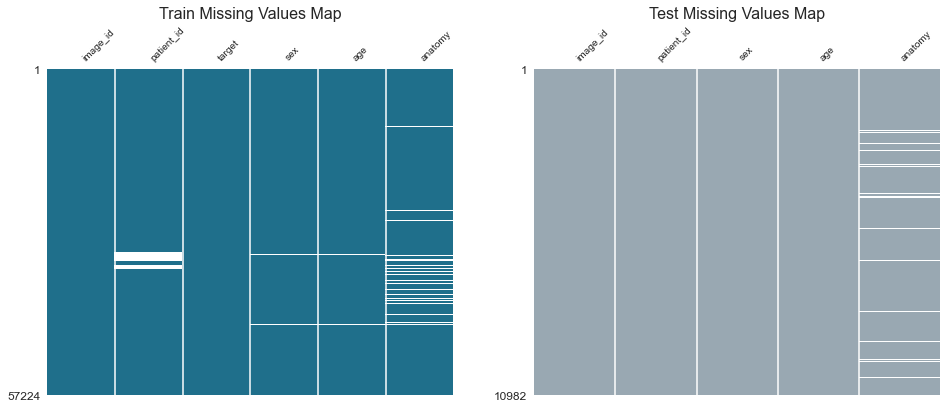

In [57]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

msno.matrix(train_df, ax = ax1, color=(31/255, 111/255, 139/255), fontsize=10)
msno.matrix(test_df, ax = ax2, color=(153/255, 168/255, 178/255), fontsize=10)

ax1.set_title('Train Missing Values Map', fontsize = 16)
ax2.set_title('Test Missing Values Map', fontsize = 16);

In [58]:
def percentage(part, whole):
  return 100 * float(part)/float(whole)

print("Train:")
print("\t patient_id: {:.2f}%".format(percentage(train_df['patient_id'].isnull().sum(), len(train_df))))
print("\t sex: {:.2f}%".format(percentage(train_df['sex'].isnull().sum(), len(train_df))))
print("\t age: {:.2f}%".format(percentage(train_df['age'].isnull().sum(), len(train_df))))
print("\t anatomy: {:.2f}%".format(percentage(train_df['anatomy'].isnull().sum(), len(train_df))))
print("Test:")
print("\t anatomy: {:.2f}%".format(percentage(test_df['anatomy'].isnull().sum(), len(train_df))))


Train:
	 patient_id: 3.63%
	 sex: 0.73%
	 age: 0.82%
	 anatomy: 5.46%
Test:
	 anatomy: 0.61%


Υπάρχουν 3 τεχνικές αντιμετωπίσεις ελλείπων τιμών.

   1. **Πρόσθεση δικιάς μας τιμής με βάση κάποιο κριτήριο**. Είναι η καλύτερη λύση σε περιπτώσεις όπου οι τιμές οι οποίες μας λείπουν από <b> μια κατηγορία</b> δεν είναι πολλές  και μπορούμε να βρούμε την μέση τιμή από τους άλλους ασθενής ή να επιλέξουμε μια τιμή με βάση κάποια άλλη κατηγορία.
   2. **Διαγραφή ολόκληρης της στήλης στην οποία  δεν υπάρχει η τιμή**. Αυτή η λύση επιλέγετε μόνο σε περιπτώσεις που ένα μεγάλο ποσοστό της  **στήλης** αποτελείται από NULL τιμές και η μέση τιμή δεν θα αποτελούσε αντιπροσωπευτικό αποτέλεσμα.
   3. **Διαγραφή της γραμμής στην οποία δεν υπάρχει η τιμή**.  Αυτή η λύση επιλέγετε μόνο σε περιπτώσεις που ένα μεγάλο ποσοστό της  **γραμμής** αποτελείται από NULL τιμές .
    
Ας ελέγξουμε την κάθε κατηγορία ξεχωριστά.

## Train

### Train: κατηγορία image_id

Ελέγχουμε αν η κάθε εικόνα έχει και μοναδικό id.

In [62]:
train_df.image_id.value_counts().max()

1

In [63]:
test_df.image_id.value_counts().max()

1

### Train: κατηγορία patient_id
Όπως είχαμε δει και στο αρχείο **preparedataset.csv** ορισμένες εικόνες από το dataset του 2019 δεν ανήκαν σε κάποιον ασθενή αλλά ξέραμε αν είναι καλοηθής ή κακοηθής. Ο πιο εύκολος τρόπος για να αντιμετωπίσουμε αυτές τις εικόνες είναι να δημιουργήσουμε ένα καινούργιο patient_id για κάθε μια από αυτές.  


Θα δώσουμε στον καθένα ένα καινούργιο μοναδικό id και αυτό θα είναι το όνομα της εικόνας τους.

In [67]:
train_df['patient_id'].fillna(train_df['image_id'], inplace = True)

Ελέγχουμε πόσες εικόνες αναλογούν στο κάθε ασθενή. 

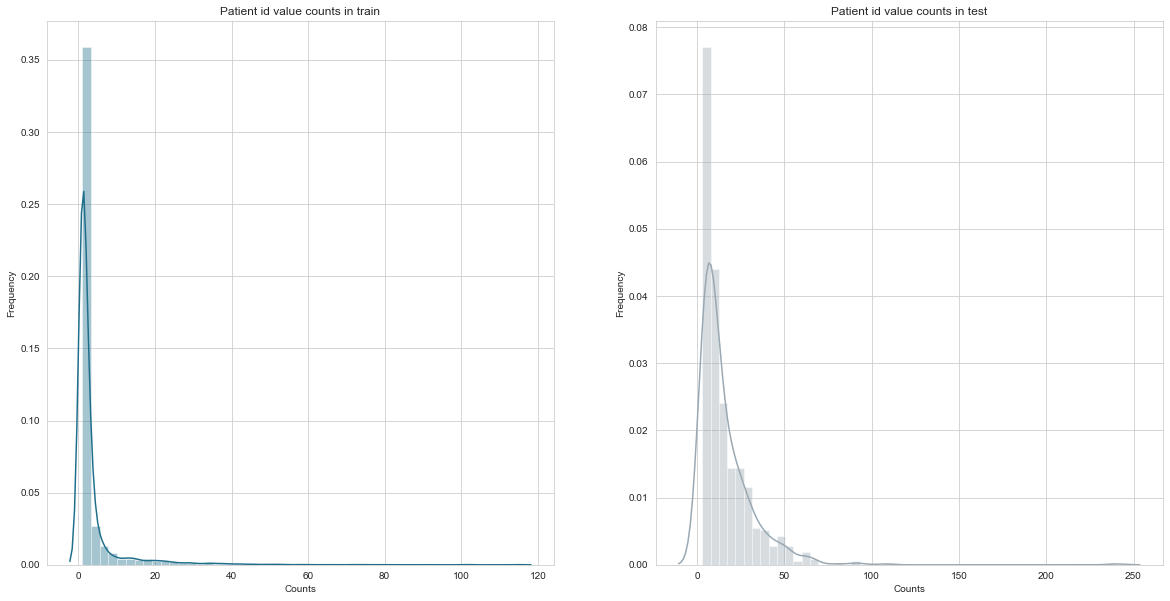

In [120]:
patient_counts_train = train_df.patient_id.value_counts()
patient_counts_test = test_df.patient_id.value_counts()

fig, ax = plt.subplots(1,2,figsize=(20,10))


sns.distplot(patient_counts_train, ax=ax[0], color=(31/255, 111/255, 139/255), kde=True);
ax[0].set_xlabel("Counts")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Patient id value counts in train");
sns.color_palette("crest", as_cmap=True)
sns.distplot(patient_counts_test, ax=ax[1], color=(153/255, 168/255, 178/255), kde=True);
ax[1].set_xlabel("Counts")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Patient id value counts in test");



In [111]:
np.quantile(patient_counts_train, 0.75) - np.quantile(patient_counts_train, 0.25)

2.0

Βλέπουμε ότι για τους περισσοτέρους ασθενείς έχουμε περίπου 1 έως 5 φωτογραφίες.  

In [113]:
print(np.quantile(patient_counts_train, 0.95))
print(np.quantile(patient_counts_test, 0.95))

16.0
46.549999999999955


Το 95% των ασθενών στο train set έχει έως 16 φωτογραφίες.
Ενώ 95% των ασθενών στο test set έχει έως 46 φωτογραφίες.

### Train: κατηγορία SEX

   Όπως βλέπουμε στο παρακάτω διάγραμμα όλες οι περιπτώσεις ασθενών στους οποίους λείπει αυτή η τιμή έχουν καλοήθη σπίλο και στους περισσότερους από αυτούς βρίσκεται στο χαμηλότερο άκρο, υψηλότερο άκρο και στο κορμό. Κανένας από αυτούς τους ασθενείς δεν έχει τιμή στην κατηγορία diagnosis.
    
    
    

Out of all NAN values, 337 are benign and 79 malignant.


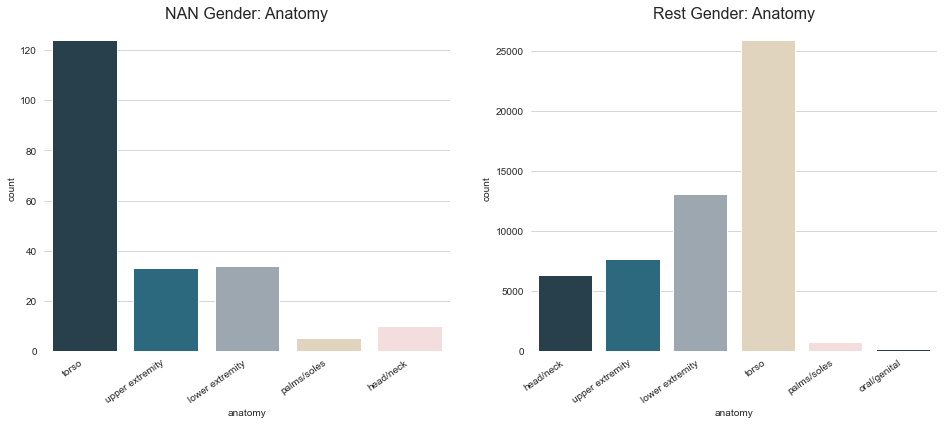

In [14]:
# Data
nan_sex = train_df[train_df['sex'].isna() == True]
is_sex = train_df[train_df['sex'].isna() == False]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_sex['anatomy'], ax = ax1, palette=colors_nude)
b = sns.countplot(is_sex['anatomy'], ax = ax2, palette=colors_nude)
ax1.set_title('NAN Gender: Anatomy', fontsize=16)
ax2.set_title('Rest Gender: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

# Benign/ Malignant check
print('Out of all NAN values, {} are benign and {} malignant.'.
                      format(nan_sex['target'].value_counts()[0], 
                             nan_sex['target'].value_counts()[1]))

 Επομένως, θα δούμε πόσοι άντρες και πόσες γυναίκες έχουν σπίλο στις συγκεκριμένες περιοχές και θα εισάγουμε το κυρίαρχο φύλο στις χαμένες τιμές.

In [15]:
# Check how many are males and how many females for targets = 0
anatomy = ['lower extremity', 'upper extremity', 'torso']
train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 0)]['sex'].value_counts()

male      22176
female    20878
Name: sex, dtype: int64

In [16]:
# Check how many are males and how many females for target = 1
train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 1)]['sex'].value_counts()

male      1941
female    1665
Name: sex, dtype: int64

In [17]:
# Impute the missing values with male
train_df['sex'].fillna("male", inplace = True) 

In [18]:
train_df['sex'].unique()

array(['male', 'female'], dtype=object)

### Train: κατηγορία AGE

Όπως βλέπουμε στο παρακάτω διάγραμμα oι ελλιπής  τιμές στην κατηγορία AGE ακολουθούν το ίδιο μοτίβο με αυτό της κατηγορίας SEX.


Βλέπουμε ότι μερικοί ασθενής έχουν τιμή 0 στην ηλικία τους.

In [19]:
train_df['age'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., 80., 20.,
       85., 15., nan, 90., 10.,  0.,  5.])

In [20]:
#train_df['age'].replace({0: np.nan}, inplace=True)

Age distributions 

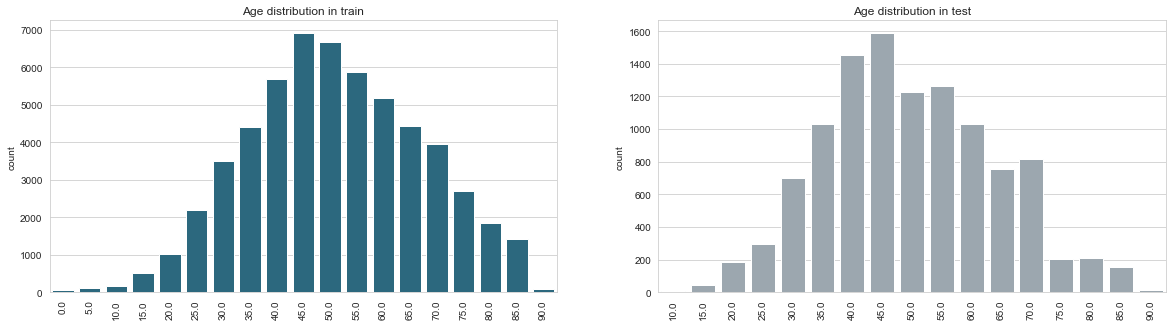

In [117]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.countplot(train_df.age, color=(31/255, 111/255, 139/255), ax=ax[0]);
labels = ax[0].get_xticklabels();
ax[0].set_xticklabels(labels, rotation=90);
ax[0].set_xlabel("");
ax[0].set_title("Age distribution in train");

sns.countplot(test_df.age, color=(153/255, 168/255, 178/255), ax=ax[1]);
labels = ax[1].get_xticklabels();
ax[1].set_xticklabels(labels, rotation=90);
ax[1].set_xlabel("");
ax[1].set_title("Age distribution in test");

Φαίνεται ότι oι ηλικίες στο train set ακολουθούν κανονική κατανομή με μια μικρή αύξηση στις μεγαλύτερες ηλικίες.   
Ενώ στο train set έχουμε κάποιες ενδιαφέρουσες κορυφές στην ηλικία των 55 και των 70 και έχουμε περισσότερους ασθενής μεγαλύτερης ηλικίας.

Out of all NAN values, 388 are benign and 83 malignant.


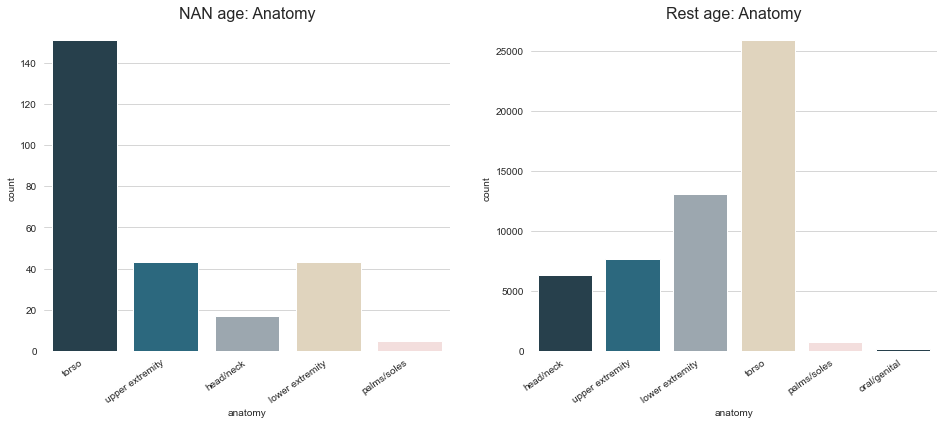

In [21]:
# Data
nan_age = train_df[train_df['age'].isna() == True]
is_age = train_df[train_df['age'].isna() == False]

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(nan_age['anatomy'], ax = ax1, palette=colors_nude)
b = sns.countplot(is_age['anatomy'], ax = ax2, palette=colors_nude)
ax1.set_title('NAN age: Anatomy', fontsize=16)
ax2.set_title('Rest age: Anatomy', fontsize=16)

a.set_xticklabels(a.get_xticklabels(), rotation=35, ha="right")
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")
sns.despine(left=True, bottom=True);

# Benign/ Malignant check
# Benign/ Malignant check
print('Out of all NAN values, {} are benign and {} malignant.'.
                      format(nan_age['target'].value_counts()[0], 
                             nan_age['target'].value_counts()[1]))

Επομένως, θα ελέγξουμε την μέση ηλικία των ατόμων που έχουν  καλοήθη σπίλο στις συγκεκριμένες περιοχές και θα εισάγουμε τον μέσο στις χαμένες τιμές. 

In [22]:
# Check the mean age for targets = 0
anatomy = ['lower extremity', 'upper extremity', 'torso']
median = train_df[(train_df['anatomy'].isin(anatomy)) & 
                  (train_df['target'] == 0) & 
                  (train_df['sex'] == 'male')]['age'].median()
print('Median is:', median)

Median is: 50.0


In [23]:
# target = 0
a = train_df.target == 0
b = train_df.age.isnull()
train_df.loc[(a & b), 'age'] = 50

In [24]:
# Check the mean age for targets = 1
median = train_df[(train_df['anatomy'].isin(anatomy)) & (train_df['target'] == 1) & (train_df['sex'] == 'male')]['age'].median()
print('Median is:', median)

Median is: 65.0


In [25]:
# target = 1
a = train_df.target == 1
b = train_df.age.isnull()
train_df.loc[(a & b), 'age'] = 65

In [26]:
train_df['age'].unique()

array([45., 50., 55., 40., 25., 35., 30., 75., 70., 65., 60., 80., 20.,
       85., 15., 90., 10.,  0.,  5.])

### Train: κατηγορία ANATOMY 
    
   Θα πρέπει να προσέξουμε ότι μέσα στις ΝULL τιμές σε αυτήν την κατηγορία ανήκουν και 9 ασθενείς με κακοήθη σπίλο οπότε, θα χρειαστεί να αντιμετωπίσουμε αυτές τις δυο περιπτώσεις διαφορετικά.  Όπως βλέπουμε στο παρακάτω διάγραμμα και οι ηλικίες αλλά και το γένος έχουν την ίδια κατανομή. 

From all missing values, 2991 are benign and 136 malignant.


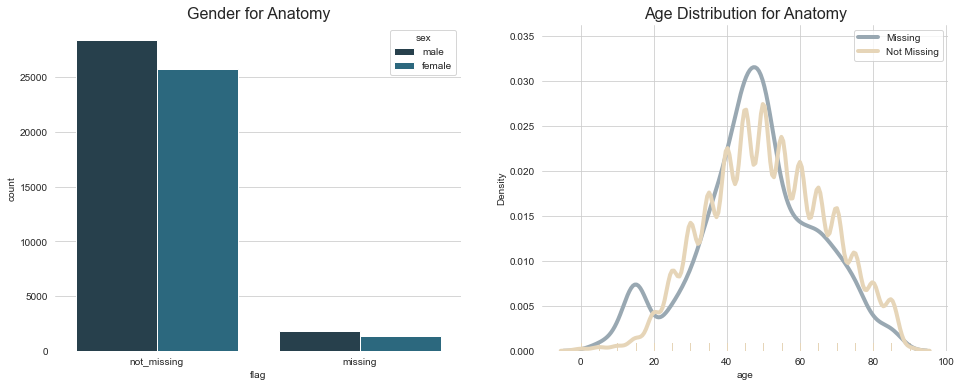

In [27]:
anatomy = train_df.copy()
anatomy['flag'] = np.where(train_df['anatomy'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1, palette=colors_nude)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'], 
             hist=False, rug=True, label='Missing', ax=ax2, 
             color=colors_nude[2], kde_kws=dict(linewidth=4))
sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
             color=colors_nude[3], kde_kws=dict(linewidth=4))

ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
#plt.legend()
ax2.legend()
sns.despine(left=True, bottom=True);

# Benign - malignant
ben_mal = anatomy[anatomy['flag'] == 'missing']['target'].value_counts()
print('From all missing values, {} are benign and {} malignant.'.format(ben_mal[0], ben_mal[1]))

Και για τις δυο περιπτώσεις σπίλων το πιο σύνηθες σημείο στο οποίο βρίσκονται είναι o κορμός. Επομένως, θα εισάγουμε αυτήν την τιμή  στις χαμένες τιμές. 

In [28]:
# Impute for anatomy
train_df['anatomy'].fillna('torso', inplace = True) 

# Test


### Test: κατηγορία ANATOMY 

   Η πληθώρα των ασθενών στους οποίους δεν υπάρχει τιμή στην κατηγορία ANATOMY είναι περίπου 70 χρόνων. 


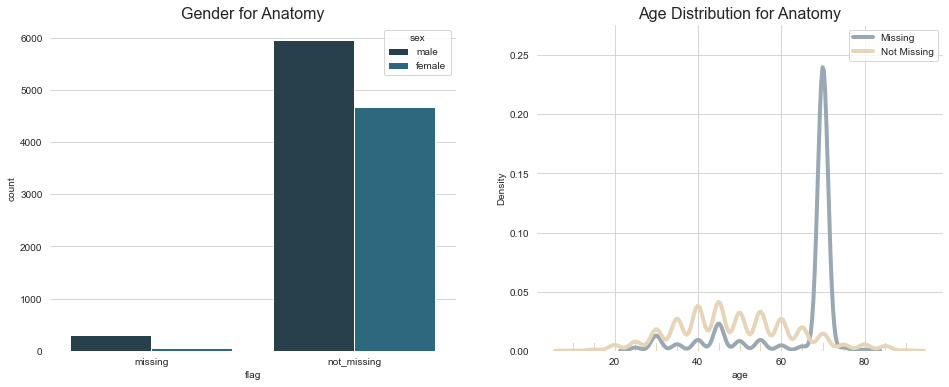

In [29]:
anatomy = test_df.copy()
anatomy['flag'] = np.where(test_df['anatomy'].isna()==True, 'missing', 'not_missing')

# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.countplot(anatomy['flag'], hue=anatomy['sex'], ax=ax1, palette=colors_nude)

sns.distplot(anatomy[anatomy['flag'] == 'missing']['age'],
             hist=False, rug=True, label='Missing', ax=ax2, 
             color=colors_nude[2], kde_kws=dict(linewidth=4, bw=0.1))

sns.distplot(anatomy[anatomy['flag'] == 'not_missing']['age'], 
             hist=False, rug=True, label='Not Missing', ax=ax2, 
             color=colors_nude[3], kde_kws=dict(linewidth=4, bw=0.1))

ax1.set_title('Gender for Anatomy', fontsize=16)
ax2.legend()
ax2.set_title('Age Distribution for Anatomy', fontsize=16)
sns.despine(left=True, bottom=True);

Όποτε, θα επιλέξουμε την τιμή με βάση τους υπόλοιπους ασθενής της ίδιας ηλικίας. 

In [30]:
# Select most frequent anatomy for age 70
value = test_df[test_df['age'] == 70]['anatomy'].value_counts().reset_index()['index'][0]

# Impute the value
test_df['anatomy'].fillna(value, inplace = True) 

In [31]:
# Save the files
directory = 'E:/Datasets/MelanomaDataset/Data'
train_df.to_csv(directory +'/train_clean.csv', index=False)
test_df.to_csv(directory +'/test_clean.csv', index=False)

# Data analysis

## Train

Target and AGE:

1. HIGH class imbalance.
2. Κατανομή ηλικιών  :
      1. Benign: ακολουθεί κανονική κατανομή.
      2. Malignant: υπάρχει μια λοξότητα προς τα αριστερά, με την κορυφή να τείνει προς τις 	μεγαλύτερες ηλικίες.


In [32]:
directory = 'E:/Datasets/MelanomaDataset/Data'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train_clean.csv')
test_df = pd.read_csv(directory + '/test_clean.csv')

In [33]:
print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df),
                                                           len(test_df)))

Train has 57,224 rows and Test has 10,982 rows.


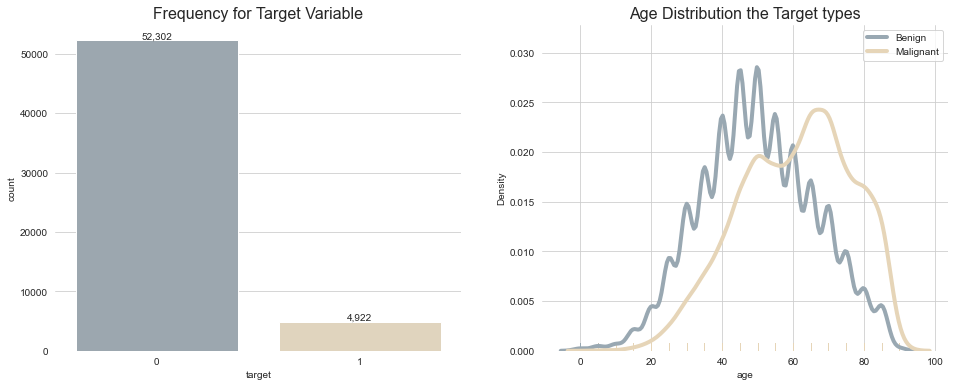

In [34]:
# Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

a = sns.countplot(data = train_df, x = 'target', palette=colors_nude[2:4],
                 ax=ax1)
b = sns.distplot(a = train_df[train_df['target']==0]['age'], ax=ax2, color=colors_nude[2], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Benign')
c = sns.distplot(a = train_df[train_df['target']==1]['age'], ax=ax2, color=colors_nude[3], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4), label='Malignant')

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
ax1.set_title('Frequency for Target Variable', fontsize=16)
ax2.legend()
ax2.set_title('Age Distribution the Target types', fontsize=16)
sns.despine(left=True, bottom=True);


Target and Genders:

    Υπάρχουν περισσότεροι άντρες από ότι γυναίκες. 



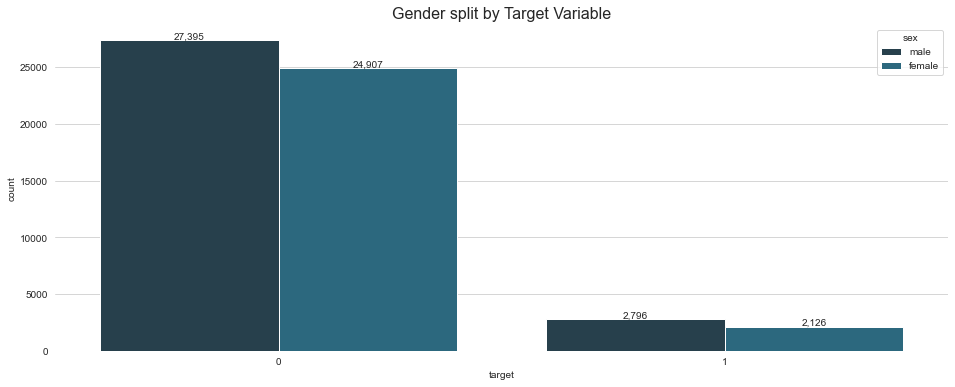

In [35]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=train_df, x='target', hue='sex', palette=colors_nude)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Gender split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);


### Anatomy and Target

Βλέπουμε ότι και στις δυο περιπτώσεις ο κορμός υπερισχύει των υπόλοιπον περιοχών. 

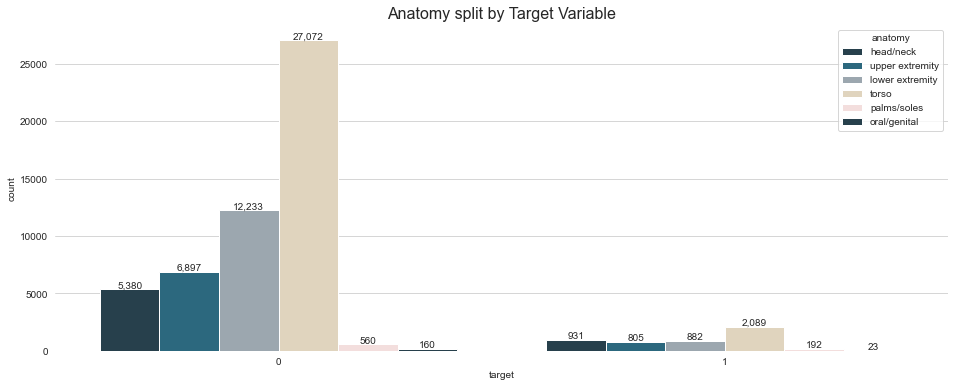

In [36]:
plt.figure(figsize=(16, 6))
a = sns.countplot(data=train_df, x='target', hue='anatomy', palette=colors_nude)

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')

plt.title('Anatomy split by Target Variable', fontsize=16)
sns.despine(left=True, bottom=True);

## Test Dataset Overview

Ακολουθούμε την ίδια διαδικασία και για το test set.

Παρατηρούμε ότι τα δεδομένα ακολουθούν παρόμοια κατανομή με τα δεδομένα του train set.

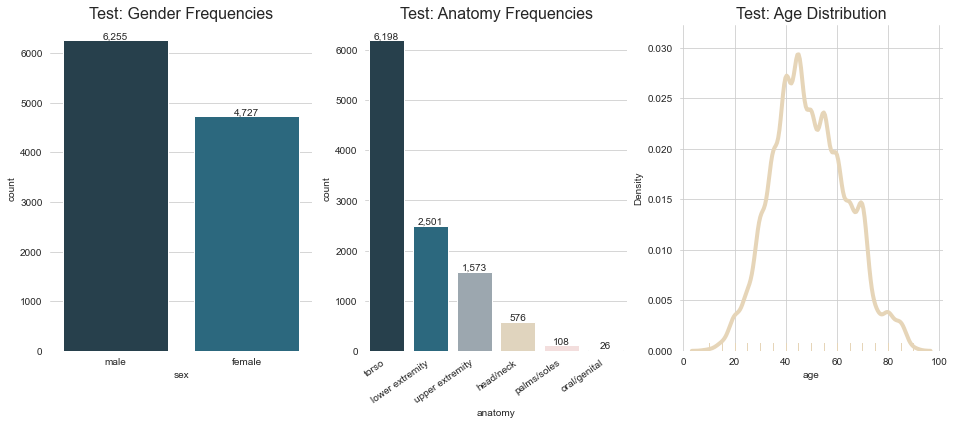

In [37]:
# Figure
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16, 6))

a = sns.countplot(test_df['sex'], palette=colors_nude, ax=ax1)
b = sns.countplot(test_df['anatomy'], ax=ax2, palette = colors_nude)
c = sns.distplot(a = test_df['age'], ax=ax3, color=colors_nude[3], 
                 hist=False, rug=True, kde_kws=dict(linewidth=4))

for p in a.patches:
    a.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
for p in b.patches:
    b.annotate(format(p.get_height(), ','), 
           (p.get_x() + p.get_width() / 2., 
            p.get_height()), ha = 'center', va = 'center', 
           xytext = (0, 4), textcoords = 'offset points')
    
b.set_xticklabels(b.get_xticklabels(), rotation=35, ha="right")

ax1.set_title('Test: Gender Frequencies', fontsize=16)
ax2.set_title('Test: Anatomy Frequencies', fontsize=16)
ax3.set_title('Test: Age Distribution', fontsize=16)
sns.despine(left=True, bottom=True);

In [39]:
# Save the files
train_df.to_csv('train_clean.csv', index=False)
test_df.to_csv('test_clean.csv', index=False)

## 4. Επεξεργασία των csv αρχείων.


Προσθέτουμε μια καινούργια στήλη με την τοποθεσία των εικόνων. Αυτό θα μας βοηθήσει αργότερα κατά την εκπαίδευση του μοντέλου μας. 

In [2]:
directory = 'E:/Datasets/MelanomaDataset/Data'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train_clean.csv')
test_df = pd.read_csv(directory + '/test_clean.csv')

In [5]:

# === JPEG ===
# Create the paths
path_train = directory + '/512x512-dataset-melanoma/' + train_df['image_id'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['image_id'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

### One Hot Encoding

In [41]:
# === TRAIN ===
to_encode = ['sex', 'anatomy']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(train_df[column])
    encoded_all.append(encoded)
    
train_df['sex'] = encoded_all[0]
train_df['anatomy'] = encoded_all[1]

In [42]:
# === TEST ===
to_encode = ['sex', 'anatomy']
encoded_all = []

label_encoder = LabelEncoder()

for column in to_encode:
    encoded = label_encoder.fit_transform(test_df[column])
    encoded_all.append(encoded)
    
test_df['sex'] = encoded_all[0]
test_df['anatomy'] = encoded_all[1]

In [7]:
train_df.head()

,image_id,patient_id,target,sex,age,anatomy,path_jpeg
0,ISIC_2637011,IP_7279968,0,1,45.0,0,E:/Datasets/MelanomaDataset/Data/512x512-datas...
1,ISIC_0015719,IP_3075186,0,0,45.0,5,E:/Datasets/MelanomaDataset/Data/512x512-datas...
2,ISIC_0052212,IP_2842074,0,0,50.0,1,E:/Datasets/MelanomaDataset/Data/512x512-datas...
3,ISIC_0068279,IP_6890425,0,0,45.0,0,E:/Datasets/MelanomaDataset/Data/512x512-datas...
4,ISIC_0074268,IP_8723313,0,0,55.0,5,E:/Datasets/MelanomaDataset/Data/512x512-datas...


In [8]:
test_df.head()

,image_id,patient_id,sex,age,anatomy,path_jpeg
0,ISIC_0052060,IP_3579794,1,70.0,4,E:/Datasets/MelanomaDataset/Data/jpeg/test/ISI...
1,ISIC_0052349,IP_7782715,1,40.0,1,E:/Datasets/MelanomaDataset/Data/jpeg/test/ISI...
2,ISIC_0058510,IP_7960270,0,55.0,4,E:/Datasets/MelanomaDataset/Data/jpeg/test/ISI...
3,ISIC_0073313,IP_6375035,0,50.0,4,E:/Datasets/MelanomaDataset/Data/jpeg/test/ISI...
4,ISIC_0073502,IP_0589375,0,45.0,1,E:/Datasets/MelanomaDataset/Data/jpeg/test/ISI...


In [9]:
# Save the files
train_df.to_csv( directory + '/train_clean.csv', index=False)
test_df.to_csv( directory + '/test_clean.csv', index=False)